In [1]:
import matplotlib.pyplot as plt
import PIL.Image as Image 
import matplotlib.image as img
import numpy as np

# read an image and convert it to a binary pattern os size [Lx, Ly]: 
# arguments = figurename, final size=[Lx, Ly]
def readPatterns(fname, size):
	this_img = Image.open(fname) # open colour image
	this_img = this_img.convert('1') # convert image to black and white
	this_img = this_img.resize(size=[size[0],size[1]]) # resize it to have the dimensions [Lx, Ly]
	this_img.save("%s_converted.png"%fname) # save converted image

	# plot the original and the converted file
	fig = plt.figure()

	# subplot on the left - original figure
	fig.add_subplot(1,2,1)		
	original = img.imread(fname)
	plt.imshow(original)
	plt.title("original")
	plt.axis('off')

	# subplot on the right - converted figure
	matrix = img.imread("%s_converted.png"%fname) # re-read from the file and convert it to a matrix of [0.,1.]
	matrix = 2*matrix-1 # convert from [0.,1.] -> [-1,1]
	fig.add_subplot(1,2,2)		
	plt.matshow(matrix, cmap=plt.cm.gray, fignum=0)
	plt.axis('off')
	plt.title("simplified")
	plt.show()
	
	# Return the pattern as a 1D vector (not as a 2D a matrix)
	return matrix.flatten()

def add_noise(pattern, noise_level):
    # Flips a fraction of pixels in a pattern to introduce noise.
    noisy_pattern = pattern.copy()
    N = len(noisy_pattern)
    flip_indices = np.random.choice(N, int(noise_level * N), replace=False)
    noisy_pattern[flip_indices] *= -1  # Flip selected pixels
    return noisy_pattern

def retrieve_pattern_asynchronous(pattern, J, steps=100):
        # Retrieve pattern - Asynchronous deterministic updates
        S = pattern.copy()
        N = len(S)
        for _ in range(steps):
            i = np.random.randint(0, N)  # Randomly select a neuron
            local_field = np.dot(J[i], S)  # Compute local field at neuron i
            S[i] = np.sign(local_field)  # Update the selected neuron
        
        return S
    
def retrieve_pattern_synchronous(pattern, J, steps=10):
    # Retrieve a pattern - Synchronous deterministic updates."""
    S = pattern.copy()
    for _ in range(steps):
        S = np.sign(J @ S)  # Synchronous update rule
    return S


In [2]:
class HopfieldNet:
    def __init__(self, N, patterns):
        """
        Initialize the Hopfield Network.
        
        Parameters:
        N (int): Number of neurons.
        patterns (list of numpy arrays): List of stored patterns, each with shape (N,).
        """
        self.N = N
        self.patterns = patterns  # Store patterns for later analysis
        self.state = np.ones(N)  # Initialize neurons to +1 state
        
        # Initialize weight matrix using Hebbian learning
        self.w = np.zeros((N, N))
        self.learn_patterns(patterns)
        
    def learn_patterns(self, patterns):
        """
        Store patterns in the weight matrix using the Hebbian learning rule.
        """
        M = len(patterns)
        for p in patterns:
            self.w += np.outer(p, p)
        self.w /= M
        np.fill_diagonal(self.w, 0)  # Ensure no self-connections

    def set_state(self, input_pattern):
        """
        Set the current state of the network.
        
        Parameters:
        input_pattern (numpy array): Initial input pattern of shape (N,).
        """
        self.state = np.copy(input_pattern)

    def energy(self):
        """
        Compute the energy of the current state.
        """
        return -0.5 * np.dot(self.state, np.dot(self.w, self.state))

    def evolve_synchronous(self, steps=10):
        """
        Perform synchronous updates until convergence.
        """
        for _ in range(steps):
            new_state = np.sign(np.dot(self.w, self.state))
            if np.array_equal(new_state, self.state):
                break  # Stop if convergence is reached
            self.state = new_state

    def evolve_asynchronous(self, steps=100):
        """
        Perform asynchronous updates until convergence.
        """
        for _ in range(steps):
            i = np.random.randint(0, self.N)  # Randomly select a neuron
            h_i = np.dot(self.w[i], self.state)
            self.state[i] = np.sign(h_i)
    
    def retrieve(self, use_asynchronous=False, steps=100):
        """
        Retrieve the attractor pattern by evolving the network.
        
        Parameters:
        use_asynchronous (bool): If True, use asynchronous updates. Default is False (synchronous).
        steps (int): Number of update steps.
        """
        if use_asynchronous:
            self.evolve_asynchronous(steps)
        else:
            self.evolve_synchronous(steps)
        return self.state

In [3]:
# Define network size and random patterns
N = 100
P = 5
Lx = Ly = 75
N = Lx*Ly # number of neurons

patterns = [np.where(np.random.rand(N) > 0.5, 1, -1) for _ in range(P)]

# Create the Hopfield Network
hopfield_net = HopfieldNet(N, patterns)

# Set a noisy version of a pattern as input
input_pattern = patterns[0].copy()
input_pattern[:10] *= -1  # Flip first 10 bits

hopfield_net.set_state(input_pattern)

# Retrieve the attractor state
retrieved_pattern = hopfield_net.retrieve(use_asynchronous=True)

# Print results
print("Original Pattern:", patterns[0])
print("Noisy Input:", input_pattern)
print("Retrieved Pattern:", retrieved_pattern)

Original Pattern: [ 1 -1 -1 ... -1  1 -1]
Noisy Input: [-1  1  1 ... -1  1 -1]
Retrieved Pattern: [-1  1  1 ... -1  1 -1]


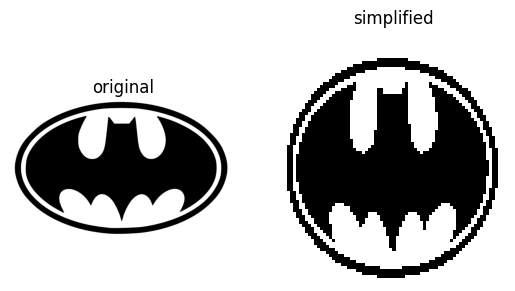

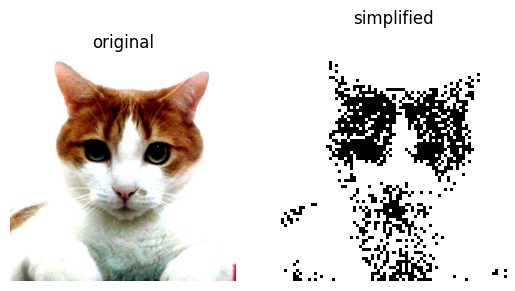

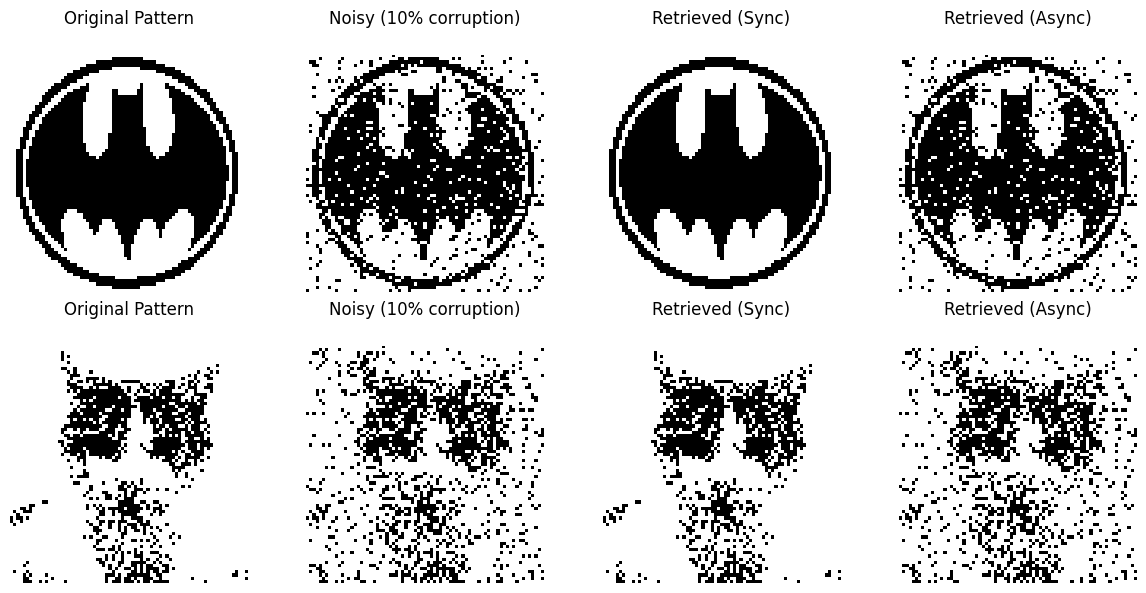

In [5]:
# Define image paths
image_paths = [
    "/Users/Filippo/Documents/UniPd/LABORATORY OF COMPUTATIONAL PHYSICS (MOD. A)/hopfield_model_and_data_reconstruction/images/stored/batman.png", 
    "/Users/Filippo/Documents/UniPd/LABORATORY OF COMPUTATIONAL PHYSICS (MOD. A)/hopfield_model_and_data_reconstruction/images/stored/cat.jpg", 
    #"/Users/Filippo/Documents/UniPd/LABORATORY OF COMPUTATIONAL PHYSICS (MOD. A)/hopfield_model_and_data_reconstruction/images/stored/jordi.jpg"
]

# Convert images to binary patterns
patterns = [readPatterns(fname, size=[Lx, Ly]) for fname in image_paths]

# Create Hopfield Network and store patterns
hopfield_net = HopfieldNet(N, patterns)

# Set noise level
noise_level = 0.1  # 10% of pixels will be flipped

# Generate noisy versions of stored patterns
noisy_patterns = [add_noise(p, noise_level) for p in patterns]

# Retrieve attractors using both synchronous and asynchronous updates
retrieved_patterns_sync = [retrieve_pattern_synchronous(p, hopfield_net.w) for p in noisy_patterns]
retrieved_patterns_async = [retrieve_pattern_asynchronous(p, hopfield_net.w) for p in noisy_patterns]

# Plot results
fig, axes = plt.subplots(len(patterns), 4, figsize=(12, len(patterns) * 3))

for i in range(len(patterns)):
    # Original Image
    axes[i, 0].matshow(np.reshape(patterns[i], (Lx, Ly)), cmap="gray")
    axes[i, 0].set_title("Original Pattern")
    axes[i, 0].axis("off")

    # Noisy Image
    axes[i, 1].matshow(np.reshape(noisy_patterns[i], (Lx, Ly)), cmap="gray")
    axes[i, 1].set_title(f"Noisy ({int(noise_level*100)}% corruption)")
    axes[i, 1].axis("off")

    # Retrieved Image (Synchronous)
    axes[i, 2].matshow(np.reshape(retrieved_patterns_sync[i], (Lx, Ly)), cmap="gray")
    axes[i, 2].set_title("Retrieved (Sync)")
    axes[i, 2].axis("off")

    # Retrieved Image (Asynchronous)
    axes[i, 3].matshow(np.reshape(retrieved_patterns_async[i], (Lx, Ly)), cmap="gray")
    axes[i, 3].set_title("Retrieved (Async)")
    axes[i, 3].axis("off")

plt.tight_layout()
plt.show()